In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math
import os
import time
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models, torchvision.datasets
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence

## Structure

The cells below show the general structure and different modules in our Transformer model

In [2]:
def attention(q, k, v, d_k, dropout=None):
    """
    Calculate attention based on the matrices, q,k,v, and the an 
    interger division on the model dimentions over the number of 
    heads. 
    """
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    
    return output


In [3]:
# Create an Embedder used to create a representaion of the 
# input matrix containing n protein's atomic coordinates
class Embedder(nn.Module):
    def __init__(self, max_coords=100000, d_model=144):
        super().__init__()
        self.embed = nn.Embedding(max_coords, d_model)
    def forward(self, x):
        y = self.embed(x)
        return y

In [4]:
# Create a MultiHeadAttention class to perform the h parallel
# attention modules. The attention scores are then combined 
# to get a final attention score
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()

        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)

        # perform linear operation and split into h heads
        k = self.k_linear(k).view(bs, 3, -1, self.h, self.d_k)
        
        q = self.q_linear(q).view(bs, 3, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, 3, -1, self.h, self.d_k)

        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)

        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, self.dropout)

        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        
        output = self.out(concat)
        output = torch.mean(output, 1)
        
    
        return output

In [5]:
# A FeedForward class takes the output from the multi-head
# attention and passes it through two linear layers to 
# result in a desireable dimention
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=20, dropout = 0.1):
        super().__init__() 
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, 3)
    def forward(self, x):
        x = self.dropout(torch.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

In [6]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
        
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        norm = torch.mean(norm, 1)
        return norm

In [7]:
# Create a Transformer model that uses an embedder, multi-head
# attention and a fully connected layer, our feed forward network
class Transformer(nn.Module):
    def __init__(self):
        super().__init__()

        self.emb = Embedder()
        self.att = MultiHeadAttention(heads=12, d_model=144)
        self.fc = FeedForward(d_model=144)

    def forward(self, x):
        x = self.emb(x)
        x = self.att(x, x, x)
        x = self.fc(x)
        return x


## Training

The following code shows the functions used to train the Transformer model

In [12]:
def get_accuracy(model, data, batch_size=2, max_N=1000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0

    loader = torch.utils.data.DataLoader(data, batch_size, shuffle=True)

    for xs, ts in loader:
        xs = xs.to(gpu)   # send xs to gpu
        # forward pass prediction
        z = model(xs)
        z = z.to(cpu)
        z = z.detach().numpy() # convert the PyTorch tensor => numpy array
        ts = ts.detach().numpy() # convert the PyTorch tensor => numpy array
        
        if dist(z, ts) < 215:
            correct += 1
            success.append(ts)
        else:
            incorrect.append(ts)
        
        N += ts.shape[0]

        if N > max_N:
            break
    return correct / N

def dist(z, t):
    """
    Return Euclidean distance of two 3D coordinates.
    """
    return math.sqrt(np.sum((z-t)**2))

In [9]:
def train(model, train_data,
          batch_size=10, learning_rate=0.001, weight_decay=0,
          epochs=500, checkpoint_path=None):
    """
    Train the PyTorch model on the dataset `train_data`, for `max_iters`
    iteration.
    This function returns the training loss, and the training
    which we can use to plot the learning curve.
    """
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    iters, losses = [], []
    iters_sub, train_accs  = [], []

    n = 0 # the number of epochs
    i = 0 # the number of iterations 
    while True:

        train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
        start = time.time()
        for xs, ts in train_loader:
            
            xs, ts = xs.to(gpu), ts.to(gpu) # send the data and labels to gpu
            zs = model(xs)
            loss = criterion(zs, ts) # compute the total loss    
            loss.backward()          # compute updates for each parameter
            optimizer.step()         # make the updates for each parameter
            optimizer.zero_grad()    # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss
            
            if i % 50 == 0:
                iters_sub.append(n)
                loss = loss.to(cpu)
                train_cost = float(loss.detach().numpy())
                train_acc = get_accuracy(model, train_data, batch_size=1)
                train_accs.append(train_acc)
                
                print("Epoch %d. Iter %d. [Train Acc %.0f%%, Loss %f]" % (
                      n, i, train_acc * 100, train_cost))

                if (checkpoint_path is not None) and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))
            
            i += 1
        # increment the epochs number
        n += 1
        end = time.time()
        if n % 50 == 0:
            print("Time of epoch %d is %f" % (n, end-start))

        if n == epochs:
            return iters, losses, iters_sub, train_accs

def plot_learning_curve(iters, losses, iters_sub, train_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    #plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

### Data and Results 

The cell below loops through a small subset of the data and filters out unusable proteins that contain either no ligands (ground truths) or no atomic coordinates (anomalies in preprocessing)

In [10]:

coords = []
ligands = []

limit = 4800
for file in os.listdir("413 preProc"):
    if limit == 0:
        break
    with open(os.path.join("413 preProc", file), "rb") as f:
        protein = pickle.load(f)
        # Skip proteins with no ligands and protiens with negative coords
        if (protein[1] == []) or (len(protein[0]) == 0) or (np.any((np.array(protein[0]) < 0))):
            continue
        coordinates = protein[0]
        coordinates = torch.tensor(coordinates)
        coordinates = coordinates.type(torch.long)
        coords.append(coordinates)

        ligand = protein[1][0]
        ligand = torch.tensor(ligand)
        ligands.append(ligand)
        f.close()
        limit -= 1
        
# Splits the data into training, validation and test sets with a 
# padding to be the same size as the largest protein (in terms of coordinates)
train_coords = pad_sequence(coords[:300], batch_first=True)
train_ligands = pad_sequence(ligands[:300], batch_first=True)

valid_coords = pad_sequence(coords[300:400], batch_first=True)
valid_ligands = pad_sequence(ligands[300:400], batch_first=True)

test_coords = pad_sequence(coords[400:], batch_first=True)
test_ligands = pad_sequence(ligands[400:], batch_first=True)

The code below sets the devices for utilizing the gpu to train data. In addition, the training, validation, and test sets are organized in a manner suitable to be used by a DataLoader (in the train function). The model is trained to an overfit model and the results are plotted. 

Using GPU
Epoch 0. Iter 0. [Train Acc 100%, Loss 75.694145]
Epoch 12. Iter 50. [Train Acc 100%, Loss 47.215687]
Epoch 25. Iter 100. [Train Acc 100%, Loss 33.217171]
Epoch 37. Iter 150. [Train Acc 100%, Loss 38.528770]
Time of epoch 50 is 1.176262
Epoch 50. Iter 200. [Train Acc 100%, Loss 32.316666]
Epoch 62. Iter 250. [Train Acc 100%, Loss 29.795990]
Epoch 75. Iter 300. [Train Acc 100%, Loss 31.131182]
Epoch 87. Iter 350. [Train Acc 100%, Loss 18.106314]
Time of epoch 100 is 1.160259
Epoch 100. Iter 400. [Train Acc 100%, Loss 18.442919]
Epoch 112. Iter 450. [Train Acc 100%, Loss 35.407032]
Epoch 125. Iter 500. [Train Acc 100%, Loss 24.975988]
Epoch 137. Iter 550. [Train Acc 100%, Loss 16.319950]
Time of epoch 150 is 1.173262
Epoch 150. Iter 600. [Train Acc 100%, Loss 20.180580]
Epoch 162. Iter 650. [Train Acc 100%, Loss 26.963339]
Epoch 175. Iter 700. [Train Acc 100%, Loss 20.545383]
Epoch 187. Iter 750. [Train Acc 100%, Loss 16.830923]
Time of epoch 200 is 1.199270
Epoch 200. Iter 800

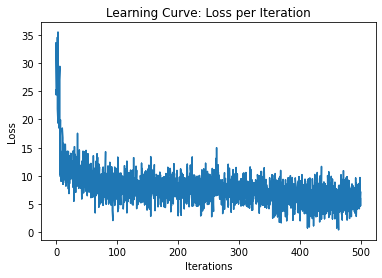

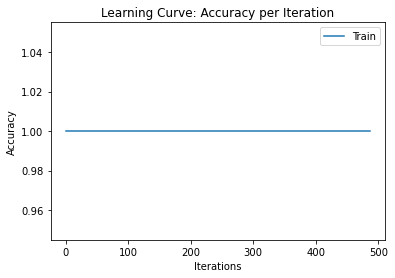

In [11]:
if torch.cuda.is_available():
    gpu = torch.device("cuda:0")
    print("Using GPU")
else:
    gpu = torch.device("cpu")
    print("Using CPU")
cpu = torch.device("cpu")  


train_data = list(zip(train_coords, train_ligands))
valid_data = list(zip(valid_coords, valid_ligands))
test_data = list(zip(test_coords, test_ligands))


transformer = transformer.to(gpu) # send model to gpu
iters, losses, iters_sub, train_accs = train(transformer, train_data[:12], batch_size=3, checkpoint_path='C:/Users/ziyya/Documents/Uni/Fall-Winter 2021-2022/Winter/Neural Nets/FInal/check2/ckpt-{}.pk')
plot_learning_curve(iters, losses, iters_sub, train_accs)

In [13]:
if torch.cuda.is_available():
    gpu = torch.device("cuda:0")
    print("Using GPU")
else:
    gpu = torch.device("cpu")
    print("Using CPU")
cpu = torch.device("cpu")  


train_data = list(zip(train_coords, train_ligands))
valid_data = list(zip(valid_coords, valid_ligands))
test_data = list(zip(test_coords, test_ligands))

success = []
incorrect = []

transformer = Transformer()
transformer.load_state_dict(torch.load('ckpt-425.pk'), strict=False)
transformer.eval()
transformer = transformer.to(gpu)
trans_acc = get_accuracy(transformer, test_data[:12], batch_size=1)

print("Transformer Accuracy:", trans_acc)
print(len(incorrect))
print(len(success))


Using GPU
Transformer Accuracy: 0.9166666666666666
1
11
